https://towardsdatascience.com/natural-language-understanding-with-sequence-to-sequence-models-e87d41ad258b


In [11]:
import pickle
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Embedding,Dense,Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.compat.v1.train import AdamOptimizer
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = '.'

def load_ds(filename = os.path.join(DATA_DIR,'/test.pkl'),verbose = False):
  with open(filename,'rb') as stream:
    ds,dicts = pickle.load(stream)
  if verbose:
      print('Done  loading: ', filename)
      print('      samples: {:4d}'.format(len(ds['query'])))
      print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
      print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
      print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
  return ds,dicts

In [3]:
# convert Pickle file to arrays
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join(DATA_DIR,filename), verbose)
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])

    if add_start_end_token:
        i2s[178] = 'BOS'
        i2s[179] = 'EOS'
        s2i['BOS'] = 178
        s2i['EOS'] = 179

    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 5)
    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []
        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])
        if add_start_end_token:
            slot_text[0] = 'BOS'
            slot_vector[0] = 178
            slot_text[-1] = 'EOS'
            slot_vector[-1]= 179
        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', '').replace('EOS',''))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])
        if i in to_show and verbose:
          print('Query text:', q)
          print('Query vector: ', query[i])
          print('Intent label: ', i2in[intent[i][0]])
          print('Slot text: ', slot)
          print('Slot vector: ', slot_vector)
          print('*'*74)
    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, query_data, intent_data, intent_data_label, slot_data

In [4]:
# load ATIS training dataset
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
input_tensor_train, target_tensor_train, \
query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

# load ATIS testing dataset
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
input_tensor_test, target_tensor_test, \
query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')

Done  loading:  ./atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS show me all flights with fares from pittsburgh to san francisco EOS
Query vector:  [178 770 581 207 429 925 415 444 682 851 739 440 179]
Intent label:  flight
Slot text:  O O O O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O
Slot vector:  [128, 128, 128, 128, 128, 128, 128, 128, 48, 128, 78, 125, 128]
**************************************************************************
Query text: BOS how much is a round trip fare from nashville to seattle EOS
Query vector:  [178 477 609 498 180 730 870 414 444 614 851 752 179]
Intent label:  airfare
Slot text:  O O O O O B-round_trip I-round_trip O O B-fromloc.city_name O B-toloc.city_name O
Slot vector:  [128, 128, 128, 128, 128, 66, 119, 128, 128, 48, 128, 78, 128]
**************************************************************************
Query text: BOS how do you travel from san francisco airp

In [5]:
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({'query': query_data_train, 'intent': intent_data_train, 'slot filling': slot_data_train})

df_small = pd.DataFrame(columns=['query','intent','slot filling'])
j = 0
for i in df.intent.unique():
  df_small.loc[j] = df[df.intent==i].iloc[0]
  j = j+1
  
df_small

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,query,intent,slot filling
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,flight,O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day
1,what is the arrival time in san francisco for the 755 am flight leaving washington,flight_time,O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name
2,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-toloc.city_name
3,what kind of aircraft is used on a flight from cleveland to dallas,aircraft,O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name
4,what kind of ground transportation is available in denver,ground_service,O O O O O O O O B-city_name
5,what 's the airport at orlando,airport,O O O O O B-city_name
6,which airline serves denver pittsburgh and atlanta,airline,O O O B-fromloc.city_name B-fromloc.city_name O B-fromloc.city_name
7,how far is it from orlando airport to orlando,distance,O O O O O B-fromloc.airport_name I-fromloc.airport_name O B-toloc.city_name
8,what is fare code h,abbreviation,O O O O B-fare_basis_code
9,how much does the limousine service cost within pittsburgh,ground_fare,O O O O B-transport_type O O O B-city_name


In [6]:
i2s_train_values = list(i2s_train.values())
df3 = pd.DataFrame()
for i in range(7):
  df3[str(i)] = i2s_train_values[i*15:(i+1)*15]
df3

,0,1,2,3,4,5,6
0,B-aircraft_code,B-arrive_time.time_relative,B-depart_date.year,B-flight_time,B-return_date.day_name,B-today_relative,I-arrive_time.time_relative
1,B-airline_code,B-booking_class,B-depart_time.end_time,B-fromloc.airport_code,B-return_date.day_number,B-toloc.airport_code,I-city_name
2,B-airline_name,B-city_name,B-depart_time.period_mod,B-fromloc.airport_name,B-return_date.month_name,B-toloc.airport_name,I-class_type
3,B-airport_code,B-class_type,B-depart_time.period_of_day,B-fromloc.city_name,B-return_date.today_relative,B-toloc.city_name,I-cost_relative
4,B-airport_name,B-compartment,B-depart_time.start_time,B-fromloc.state_code,B-return_time.period_mod,B-toloc.country_name,I-depart_date.day_name
5,B-arrive_date.date_relative,B-connect,B-depart_time.time,B-fromloc.state_name,B-return_time.period_of_day,B-toloc.state_code,I-depart_date.day_number
6,B-arrive_date.day_name,B-cost_relative,B-depart_time.time_relative,B-meal,B-round_trip,B-toloc.state_name,I-depart_date.today_relative
7,B-arrive_date.day_number,B-day_name,B-economy,B-meal_code,B-state_code,B-transport_type,I-depart_time.end_time
8,B-arrive_date.month_name,B-day_number,B-fare_amount,B-meal_description,B-state_name,I-airline_name,I-depart_time.period_of_day
9,B-arrive_date.today_relative,B-days_code,B-fare_basis_code,B-mod,B-stoploc.airport_code,I-airport_name,I-depart_time.start_time


In [7]:
def max_length(tensor):
    return max(len(t) for t in tensor)

# Helper function to pad the query tensor and slot (target) tensor to the same length. 
# Also creates a tensor for teacher forcing.
def create_tensors(input_tensor, target_tensor, nb_sample=9999999, max_len=0):
    len_input, len_target  = max_length(input_tensor), max_length(target_tensor)
    len_input = max(len_input,max_len)
    len_target = max(len_target,max_len)
    

    # Padding the input and output tensor to the maximum length
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=len_input,
                                                                 padding='post')

    teacher_data = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=len_target , 
                                                                  padding='post')
    
    target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
    target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
    target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))
    
    nb = len(input_data)
    p = np.random.permutation(nb)
    input_data = input_data[p]
    teacher_data = teacher_data[p]
    target_data = target_data[p]

    return input_data[:min(nb_sample, nb)], teacher_data[:min(nb_sample, nb)], target_data[:min(nb_sample, nb)],len_input, len_target 
           
input_data_train, teacher_data_train, target_data_train, \
                  len_input_train, len_target_train  = create_tensors(input_tensor_train, target_tensor_train)
input_data_test, teacher_data_test, target_data_test, \
                 len_input_test, len_target_test  = create_tensors(input_tensor_test, target_tensor_test, max_len=len_input_train)


In [8]:
def get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test):
    vocab_in_size = len({**t2i_train, **t2i_test})
    vocab_out_size = len({**s2i_train, **s2i_test})
    return vocab_in_size, vocab_out_size
  
vocab_in_size, vocab_out_size = get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test)
vocab_in_size, vocab_out_size

(943, 129)

In [9]:
BUFFER_SIZE = len(input_data_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024

encoder_inputs = Input(shape=(len_input_train,))
encoder_emb = Embedding(input_dim = vocab_in_size,output_dim = embedding_dim)
encoder_lstm = CuDNNLSTM(units = units,return_sequences = True,return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))
encoder_states = [state_h,state_c]

decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)

decoder_d1 = Dense(units,activation = 'relu') 
decoder_d2 = Dense(vocab_out_size, activation="softmax")
decoder_out = decoder_d2(Dropout(rate=.4)(decoder_d1(Dropout(rate=.4)(decoder_lstm_out))))

model = Model([encoder_inputs,decoder_inputs],decoder_out)
model.compile(optimizer=AdamOptimizer(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 48, 256)      241408      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    33024       input_2[0][0]                    
______________________________________________________________________________________________

In [10]:
epochs = 50
history = model.fit([input_data_train, teacher_data_train], target_data_train,
                 batch_size=BATCH_SIZE,
                 epochs=epochs,
                 validation_data=([input_data_test, teacher_data_test], target_data_test))
                 
def plot_training_accuracy(history):

  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()
  
plot_training_accuracy(history)

Epoch 1/50
78/78 [==============================] - 21s 263ms/step - loss: 0.9010 - sparse_categorical_accuracy: 0.8507 - val_loss: 0.4580 - val_sparse_categorical_accuracy: 0.8923
Epoch 2/50
78/78 [==============================] - 6s 77ms/step - loss: 0.4498 - sparse_categorical_accuracy: 0.8941 - val_loss: 0.3928 - val_sparse_categorical_accuracy: 0.9123
Epoch 3/50
78/78 [==============================] - 6s 78ms/step - loss: 0.3661 - sparse_categorical_accuracy: 0.9146 - val_loss: 0.3216 - val_sparse_categorical_accuracy: 0.9206
Epoch 4/50
78/78 [==============================] - 6s 79ms/step - loss: 0.3211 - sparse_categorical_accuracy: 0.9200 - val_loss: 0.2936 - val_sparse_categorical_accuracy: 0.9265
Epoch 5/50
78/78 [==============================] - 6s 79ms/step - loss: 0.3000 - sparse_categorical_accuracy: 0.9247 - val_loss: 0.2793 - val_sparse_categorical_accuracy: 0.9277
Epoch 6/50
78/78 [==============================] - 6s 79ms/step - loss: 0.2881 - sparse_categorical_ac

NameError: ignored

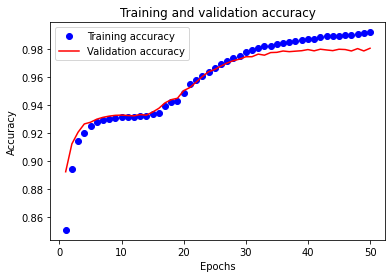

In [12]:
def plot_training_accuracy(history):

  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()
  
plot_training_accuracy(history)

In [13]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).
inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units,), name="state_input_h")
state_input_c = Input(shape=(units,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])
                  
def preprocess_query(w):
    w = w.rstrip().strip().lower()
    w = "BOS " + w + " EOS"
    return w
  
# Converts the given query (just a string) into a vector of word IDs
# using the language specified. This can be used for either the input (query)
# or target (slot)
# Output is 1-D: [timesteps/words]
def query_to_vector(query, len_input=len_input_train, t2i=t2i_train):
    pre = preprocess_query(query)
    vec = np.zeros(len_input)
    query_list = [t2i[s] for s in pre.split(' ')]
    for i,w in enumerate(query_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
# return a predicted slot string.
def predict_slots(input_query, infenc_model, infmodel, 
                  len_input=len_input_train, 
                  t2i=t2i_train, s2i=s2i_train, i2s=i2s_train,
                  len_target=len_target_train,
                  attention=False):
    sent_len = len(input_query.split())
    sv = query_to_vector(input_query, len_input, t2i)
    # Reshape so we can use the encoder model. New shape=[samples,sequence length]
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = s2i["O"]
    stop_vec = s2i["O"]
    # We will continuously feed cur_vec as an input into the decoder to produce the next word,
    # which will be assigned to cur_vec. Start it with "EOS".
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "BOS"
    output_query = ""
    # Start doing the feeding. Terminate when the model predicts an "EOS" or we reach the end
    # of the max target slot length.
    while cur_word != "EOS" and i < (len_target-1) and i < sent_len+1:
        i += 1
        if cur_word != "BOS":
            output_query = output_query + " " + cur_word
        x_in = [cur_vec, sh, sc]
        # This will allow us to accomodate attention models, which we will talk about later.
        if attention:
            x_in += [emb_out]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        # The output of the model is a massive softmax vector with one spot for every possible word. Convert
        # it to a word ID using argmax().
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = i2s[np.argmax(nvec[0,0])]
    return output_query
    
input_query = "what is the cheapest flight from boston to san francisco"
print(predict_slots(input_query, encoder_model, inf_model))

 O O O B-cost_relative O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name


In [14]:
def evaluate_slot_filling(queries, true_slots,
                          len_input=len_input_test, 
                          t2i=t2i_test, s2i=s2i_test, i2s=i2s_test,
                          len_target=len_target_test):
  predicted_slots = []
  for q in queries:
    s = predict_slots(q, encoder_model, inf_model,
                      len_input, 
                      t2i, s2i, i2s,
                      len_target)
    predicted_slots.append(s)
  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(true_slots, predicted_slots, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(true_slots, predicted_slots, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(true_slots, predicted_slots, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(true_slots, predicted_slots, weights=(0.25, 0.25, 0.25, 0.25)))
  
evaluate_slot_filling(query_data_test, slot_data_test)

NameError: ignored